# Lab 1: image rectification

This lab has two main goals:

1) Get more familiar with the hierarchy of 2D transformation <br>

2) Remove the projective distortion of an image of a planar object (image rectification)

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [1]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil
from utils import line_draw, plot_img
from scipy import linalg as SCIPY_LA

import sys

In [2]:
# utility functions
def array_to_image(I_array):
    return Image.fromarray(I_array.astype(np.uint8))

def get_points(A, idx):
    p1 = [A[idx, 0], A[idx, 1], 1] # initial point in line i
    p2 = [A[idx, 2], A[idx, 3], 1] # final point in line i
    return p1,p2

def draw_image_lines(I, lines, axis=None):
    canv = ImageDraw.Draw(I)
    point_color = (0, 0, 255)
    
    for l in lines:
        line_draw(l, canv, I.size)

    plot_img(I)
    return

def get_diagonal_lines(lines):
    
    # l1 and l2 are orthogonal w.r.t l3 and l4, but l1 and l2 are parallel
    l1,l2,l3,l4 = lines
    
    # Intersection points between orthogonal lines
    pi1 = np.cross(l1, l3)
    pi2 = np.cross(l1, l4)
    pi3 = np.cross(l2, l3)
    pi4 = np.cross(l2, l4)

    # Diagonal (transformed) lines that cross the intersection points between orthogonal lines
    ld1 = np.cross(pi1,pi4)
    ld2 = np.cross(pi2,pi3)
    
    return ld1,ld2

def correct_transformed_lines(lines, corners):
    x_corner_min = np.min(np.transpose(corners)[0])
    y_corner_min = np.min(np.transpose(corners)[1])

    corrected_lines = []
    
    for l in lines:
        corrected_lines.append([l[0], l[1], l[2] + x_corner_min*l[0] + y_corner_min*l[1]])
    
    return corrected_lines

def get_line_inf(lines):
    l1,l2,l3,l4 = lines
    # Vanishing points from parallel lines
    v1 = np.cross(l1, l2)
    v2 = np.cross(l3, l4)

    # Line at infinity defined by v1, v2
    l_inf = np.cross(v1,v2)
    
    return np.divide(l_inf, l_inf[2])

def get_Hap(l_inf):
    # Ha<-p to perform affine rectification
    Hap = np.array([[1,0,0],
                    [0,1,0], 
                    [l_inf[0],l_inf[1],l_inf[2]]])
    return Hap

def get_Hsa(orthogonal_lines):
    
    # Two pairs of orthogonal lines (l_orth1-l_orth2 and l_orth3-l_orth4)
    l_orth1, l_orth2 = orthogonal_lines[0]
    l_orth3, l_orth4 = orthogonal_lines[1]
    
    # Equation between lines (l=(l1,l2,l3) and m=(m1,m2,m3)) that are orthogonal in the world: 
    # (l1*m1, l1*m2+l2*m1, l2*m2)*s = 0, where s=(s1,s2,s3) 
    eq1 = np.array([l_orth1[0]*l_orth2[0], l_orth1[0]*l_orth2[1]+l_orth1[1]*l_orth2[0], l_orth1[1]*l_orth2[1]])
    eq2 = np.array([l_orth3[0]*l_orth4[0], l_orth3[0]*l_orth4[1]+l_orth3[1]*l_orth4[0], l_orth3[1]*l_orth4[1]])

    # The solution s of the homogeneous system of two equations with three unknowns is its null vector 
    s = SCIPY_LA.null_space(np.array([eq1, eq2]), np.array([0,0]))

    # S = KK^T, being K a possible matrix A that can be used to metrically rectify the image
    S = [[s[0][0], s[1][0]], 
         [s[1][0], s[2][0]]]

    K = LA.cholesky(S)

    K_inv = LA.inv(K)
    Hsa =  [[K_inv[0][0], K_inv[0][1], 0],
            [K_inv[1][0], K_inv[1][1], 0],
            [0, 0, 1]]
    return Hsa

def get_angle(l, m):
    # Normal Vectors (l_normal = (normal(l), 1))
    l_normal = np.array([np.divide(l[0],l[2]), np.divide(l[1],l[2]), 1])
    m_normal = np.array([np.divide(m[0],m[2]), np.divide(m[1],m[2]), 1])

    # Absolute conic
    omega_inf = [[1, 0, 0], 
                 [0, 1, 0],
                 [0, 0, 0]]

    # Steps to compute the angle between two lines (lecture 2b)
    omega_inf_l = np.matmul(omega_inf, np.transpose(l_normal))
    omega_inf_m = np.matmul(omega_inf, np.transpose(m_normal))
        
    sqrt_l = np.sqrt(np.dot(omega_inf_l, l_normal))
    sqrt_m = np.sqrt(np.dot(omega_inf_m, m_normal))
    
    cos_l_m = (np.dot(omega_inf_l, m_normal)/(sqrt_l * sqrt_m))

    angle_rad = np.arccos(cos_l_m) # radians
    angle_deg = (angle_rad * 180)/np.pi # degrees 
    
    return angle_deg

## **1. Applying image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to animage.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so as to 
contain the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [3]:
def apply_H(I, H, corners=None):
    
    h, w, n_channels = I.shape
  
    # If we specify the image corners -> useful to perform metric rectification after an affine rect.
    if corners is not None:
        tl,tr,bl,br = corners
        tl = [tl[0], tl[1], 1]
        tr = [tr[0], tr[1], 1]
        bl = [bl[0], bl[1], 1]
        br = [br[0], br[1], 1]
    else:
        tl = [0,0,1]
        tr = [w,0,1]
        bl = [0,h,1]
        br = [w,h,1]
    
    # Transformed (rectified) image corners in homogeneous coordinates
    tl_rect = np.matmul(H,np.transpose(tl))
    tr_rect = np.matmul(H,np.transpose(tr))
    bl_rect = np.matmul(H,np.transpose(bl))
    br_rect = np.matmul(H,np.transpose(br))
    corners_rect_h = np.asarray([tl_rect, tr_rect, br_rect, bl_rect])
    
    # Transformed (rectified) image corners in cartesian coordinates
    corners_rect_c = np.empty(shape=(4, 2))
    corners_rect_c[:, 0] = np.divide(corners_rect_h[:, 0], corners_rect_h[:, 2])
    corners_rect_c[:, 1] = np.divide(corners_rect_h[:, 1], corners_rect_h[:, 2])
        
    # Get max/min x and y values of the transformed image to automatically compute the output width and height
    x_max = int(np.max(corners_rect_c[:,0]))
    x_min = int(np.min(corners_rect_c[:,0]))
    y_max = int(np.max(corners_rect_c[:,1]))
    y_min = int(np.min(corners_rect_c[:,1]))
    w_out = x_max-x_min+1
    h_out = y_max-y_min+1

    # Mesh grid of the (x,y,1) coordinates of the transformed (output) image
    x = np.arange(x_min, x_max+1, 1)
    y = np.arange(y_min, y_max+1, 1)
    X, Y = np.meshgrid(x, y, indexing='ij')
    Z = np.ones((w_out, h_out))
    rect_coords_h = np.dstack((X, Y, Z)).reshape((w_out, h_out, 3))
    
    # Mesh grid of the (x,y,1) coordinates of the original (input) image
    original_coords_h = rect_coords_h.copy()
    
    # Inverse warping: for each (x',y',1) of the transformed image, multiply by the 
    # inverse of H to get the corresponding (x,y,1) in the original image
    original_coords_h = np.dot(original_coords_h, np.transpose(LA.inv(H)))
    
    # From homogeneous to cartesian coordinates of the original image
    original_coords_h = original_coords_h.reshape(w_out*h_out, 3)
    original_coords_c = np.empty(shape=(w_out*h_out, 2))
    original_coords_c[:, 0] = np.divide(original_coords_h[:, 0], original_coords_h[:, 2])
    original_coords_c[:, 1] = np.divide(original_coords_h[:, 1], original_coords_h[:, 2])
    original_coords_c = original_coords_c.reshape(w_out, h_out, 2)
    
    # Map the values from the original image to the rectified (output) image using interpolation
    x_coords = original_coords_c[:,:,0].reshape(w_out,h_out)
    y_coords = original_coords_c[:,:,1].reshape(w_out,h_out)
    output_coords = np.zeros((w_out, h_out, n_channels))
    for i in range(n_channels):
        output_coords[:, :, i] = map_coordinates(I[:,:,i],[y_coords, x_coords], mode='constant')
    
    # We return the new axis of the rectified (output) image for plotting purposes
    rect_image_axis = [x_min, x_max, y_max, y_min]
    
    # We also return the corners of the rectified image (corners_rect_c) so that we 
    # can perform the metric rectification properly after the affine one.
    return np.transpose(output_coords, (1,0,2)), rect_image_axis, corners_rect_c

### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a similarity transformation. </span>

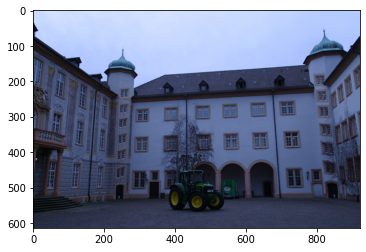

In [4]:
# Format of H in the slides (Lecture 2a)
def create_H(R, s, t):
    return [[s*R[0][0], s*R[0][1], t[0]], 
            [s*R[1][0], s*R[1][1], t[1]], 
            [0, 0, 1]]

def create_rotation_matrix(theta):
    return [[np.cos(theta), -np.sin(theta)], 
            [np.sin(theta), np.cos(theta)]]

img_path = "./Data/0000_s.png"
I = Image.open(img_path)
plot_img(I)

# theta: rotation angle
# s: scaling factor
# t: translation vector

# Only Scale
theta = 0
R = create_rotation_matrix(theta) #Rotation matrix (https://en.wikipedia.org/wiki/Rotation_matrix)
s = 0.5
t = [0, 0]
I_scale, axis_scale, _ = apply_H(np.array(I), create_H(R, s, t))
I_scale = array_to_image(I_scale)

# Scale and rotation
theta = 0.1*np.pi
R = create_rotation_matrix(theta) #Rotation matrix (https://en.wikipedia.org/wiki/Rotation_matrix)
I_scale_rotation, axis_scale_rotation, _ = apply_H(np.array(I), create_H(R, s, t))
I_scale_rotation = array_to_image(I_scale_rotation)

# Scale, rotation and translation
t = [400, 300]
I_scale_translation_rotation, axis_scale_translation_rotation, _ = apply_H(np.array(I), create_H(R, s, t))
I_scale_translation_rotation = array_to_image(I_scale_translation_rotation)

### Scale only

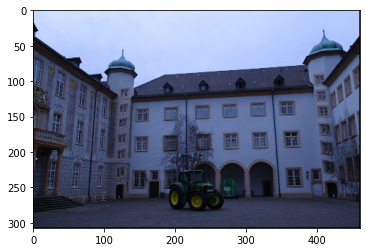

In [5]:
plot_img(I_scale, axis=axis_scale, save=True, title='1-1-similarity_scale.png')

### Scale and Rotation

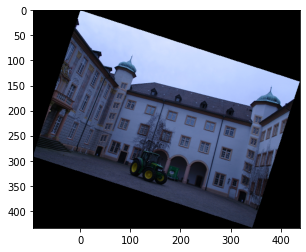

In [6]:
plot_img(I_scale_rotation, axis=axis_scale_rotation, save=True, title='1-1-similarity_scale_rotation.png')

### Scale, translation and Rotation

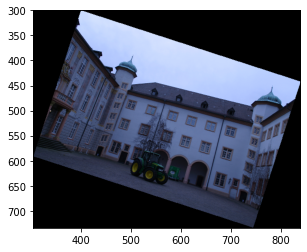

In [7]:
plot_img(I_scale_translation_rotation, axis=axis_scale_translation_rotation, save=True, title='1-1-similarity_all.png')

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces an affine transformation.  </span>

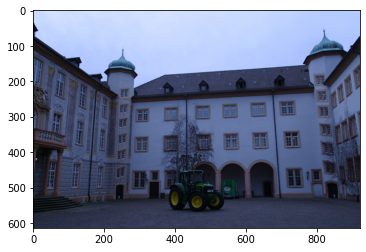

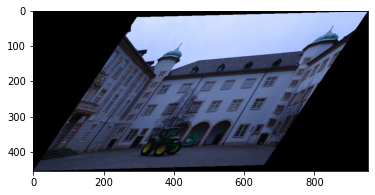

In [11]:
# Format of H in the slides (Lecture 2a)
theta = 0.1*np.pi;
phi = 0.3*np.pi;
s = [1, 0.5];
t = [30, 30];

R_theta = [[np.cos(theta), -np.sin(theta), 0], 
           [np.sin(theta), np.cos(theta), 0], 
           [0, 0, 1]]
  
R_phi1 = [[np.cos(phi), -np.sin(phi), 0], 
          [np.sin(phi), np.cos(phi), 0], 
          [0, 0, 1]]
  
R_phi2 = [[np.cos(-phi), -np.sin(-phi), 0], 
          [np.sin(-phi), np.cos(-phi), 0], 
          [0, 0, 1]]
  
S = [[s[0], 0, 0],
     [0, s[1], 0],
     [0, 0, 1]]

T = [[0, 0, t[0]],
     [0, 0, t[1]],
     [0, 0, 0]]

Haff = np.matmul(R_theta, np.matmul(R_phi2, np.matmul(S, R_phi1))) + T
   
img_path = "./Data/0000_s.png"
I = Image.open(img_path)
I_aff, aff_axis, _ = apply_H(np.array(I), Haff)

plot_img(I)
plot_img(array_to_image(I_aff))

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

In [21]:
# From lecture 2a -> SVD decomposition: R_theta*(transpose(R_phi2)*D*R_phi1) = U*transpose(V)*(V*D*transpose(V))
U,D,V = LA.svd(Haff[:2,:2])
print(f'U: {U},\nD: {D},\nV: {V}')

R1_svd = np.matmul(U, V)
R2_svd = V
S_svd = np.diag(D)
T_svd = np.array([t[0],t[1]])
print(f'R1_svd: {R1_svd},\nR2_svd: {R2_svd},\nS_svd: {S_svd},\nT_svd: {T_svd}')

U: [[-0.80901699  0.58778525]
 [ 0.58778525  0.80901699]],
D: [1.  0.5],
V: [[-0.58778525  0.80901699]
 [ 0.80901699  0.58778525]]
R1_svd: [[ 0.95105652 -0.30901699]
 [ 0.30901699  0.95105652]],
R2_svd: [[-0.58778525  0.80901699]
 [ 0.80901699  0.58778525]],
S_svd: [[1.  0. ]
 [0.  0.5]],
T_svd: [30 30]


<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

In [23]:
A = np.matmul(R1_svd, np.matmul(np.matmul(V, S_svd), R2_svd))

Haff_svd = np.array([[A[0][0], A[0][1], T_svd[0]], 
                  [A[1][0], A[1][1], T_svd[1]], 
                  [0, 0, 1]])

print(f'Haff:\n{Haff},\nHaff_svd:\n{Haff_svd}')
mse = ((Haff - Haff_svd)**2).mean(axis=None)
print(f'MSE = {mse}')

Haff:
[[ 7.13292387e-01 -4.81762746e-01  3.00000000e+01]
 [-1.82372542e-02  7.13292387e-01  3.00000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]],
Haff_svd:
[[ 7.13292387e-01 -4.81762746e-01  3.00000000e+01]
 [-1.82372542e-02  7.13292387e-01  3.00000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
MSE = 1.40860376210322e-32


<span style='color:Green'> - verify that the proper sequence of the four previous
transformations over the image I produces the same transformed image as before.  </span>

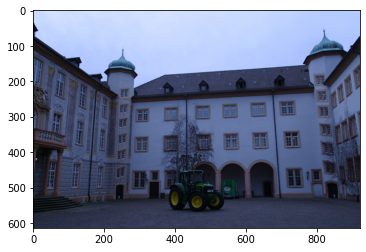

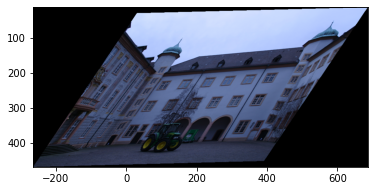

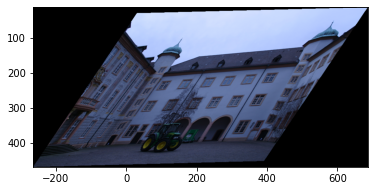

In [24]:
I_aff_svd, aff_svd_axis, _ = apply_H(np.array(I), Haff_svd)

plot_img(I)
plot_img(array_to_image(I_aff), axis=aff_axis, save=True, title='1-2-affine1.png')
plot_img(array_to_image(I_aff_svd), axis=aff_svd_axis, save=True, title='1-2-affineSVD.png')

### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a projective transformation.  </span>

/home/oscar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/home/oscar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


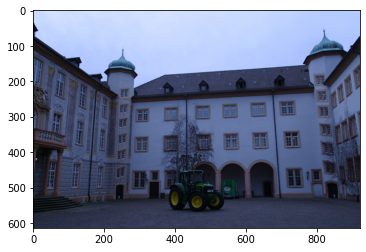

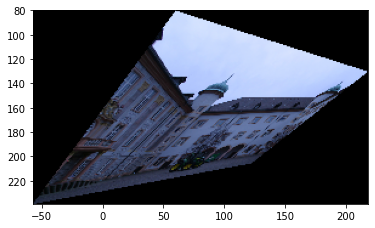

In [25]:
# Format of H in the slides (Lecture 2a)

A = [[0.5, -0.25],[0.25, 0.5]] # random non-singular 2x2 matrix
t = [60, 80] # translation Vector (random values)
v = [0.0015, 0.001] 

Hproj = [[A[0][0], A[0][1], t[0]], 
         [A[1][0], A[1][1], t[1]], 
         [v[0], v[1], 1]]

img_path = "./Data/0000_s.png"
I = Image.open(img_path)

I_proj, axis_projective, _ = apply_H(np.array(I), Hproj)
     
plot_img(I)
plot_img(array_to_image(I_proj), axis=axis_projective)

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

In [26]:
# load images and lines
img_path = "./Data/0000_s.png"
I = Image.open(img_path)

lines_path = "./Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
p1,p2 = get_points(A, 423)
p3,p4 = get_points(A, 239)
p5,p6 = get_points(A, 711)
p7,p8 = get_points(A, 564)

<span style='color:Green'> - Compute the lines l1, l2, l3, l4, that pass through the different pairs of points.  </span>

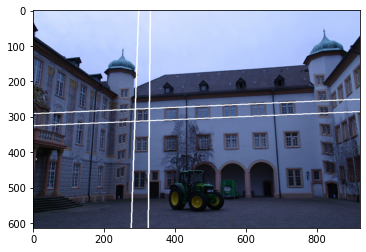

In [27]:
#The line that crosses between two points is l = p1 x p2 
l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)

draw_image_lines(I.copy(), [l1,l2,l3,l4])

<span style='color:Green'> - Compute the homography that affinely rectifies the image </span>

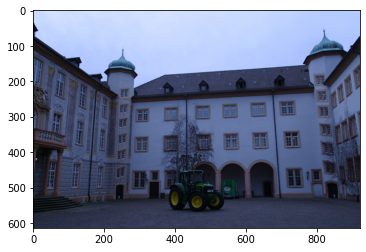

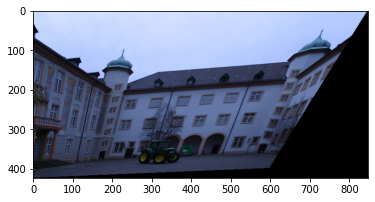

In [28]:
l_inf = get_line_inf([l1,l2,l3,l4])
Hap = get_Hap(l_inf)

I_aff_rectified, _, affine_corners = apply_H(np.array(I),Hap)

plot_img(I)
plot_img(array_to_image(I_aff_rectified))

<span style='color:Green'> - Compute the transformed lines lr1, lr2, lr3, lr4 and
      show the transformed lines in the transformed image. </span>

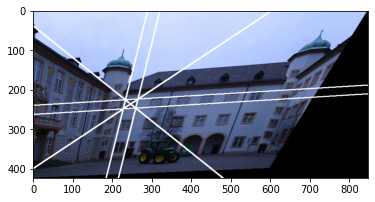

In [38]:
Hap_inv_t = np.transpose(LA.inv(Hap))

# Compute the affinely rectified (transformed) lines (lr1, lr2...)
lr1 = np.matmul(Hap_inv_t, l1)
lr2 = np.matmul(Hap_inv_t, l2)
lr3 = np.matmul(Hap_inv_t, l3)
lr4 = np.matmul(Hap_inv_t, l4)

# lr1 and lr2 are orthogonal w.r.t lr3 and lr4, but lr1 and lr2 are parallel
lr5, lr6 = get_diagonal_lines([lr1,lr2,lr3,lr4])

affine_corrected_lines = correct_transformed_lines([lr1,lr2,lr3,lr4,lr5,lr6], affine_corners)

draw_image_lines(array_to_image(I_aff_rectified), affine_corrected_lines)

<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>

In [30]:
# Angle between parallel lines (l1-l2 and l3-l4) before the affine rectification (not 0)
angle_l1_l2 = get_angle(l1, l2)
angle_l3_l4 = get_angle(l3, l4)
print(f'Angles between parallel lines before the affine rectification --> l1/l2: {angle_l1_l2:.2f};  l3/l4: {angle_l3_l4:.2f}')

# Angle between parallel lines (lr1-lr2 and lr3-lr4) after the affine rectification (should be 0)
angle_lr1_lr2 = get_angle(lr1, lr2)
angle_lr3_lr4 = get_angle(lr3, lr4)
print(f'Angles between parallel lines after the affine rectification --> lr1/lr2: {angle_lr1_lr2:.2f};  lr3/lr4: {angle_lr3_lr4:.2f}')

Angles between parallel lines before the affine rectification --> l1/l2: 0.10;  l3/l4: 1.34
Angles between parallel lines after the affine rectification --> lr1/lr2: 0.00;  lr3/lr4: 0.00


#### **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

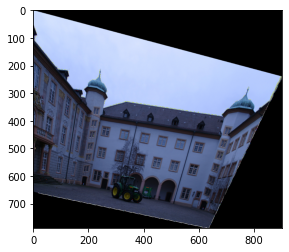

In [33]:
#Two pairs of orthogonal lines (lr1-lr3 and lr5-lr6)
Hsa = get_Hsa([[lr1,lr3], [lr5,lr6]])

I_metric_rectified, _, metric_corners = apply_H(I_aff_rectified, Hsa, affine_corners)
plot_img(array_to_image(I_metric_rectified))

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.

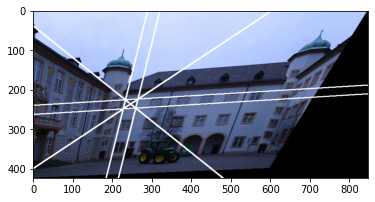

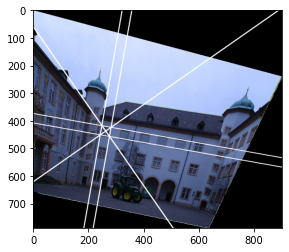

In [39]:
Has_t = np.transpose(LA.inv(Hsa))

# Compute the transformed lines
lrm1 = np.matmul(Has_t, lr1)
lrm2 = np.matmul(Has_t, lr2)
lrm3 = np.matmul(Has_t, lr3)
lrm4 = np.matmul(Has_t, lr4)
lrm5 = np.matmul(Has_t, lr5)
lrm6 = np.matmul(Has_t, lr6)

metric_corrected_lines = correct_transformed_lines([lrm1,lrm2,lrm3,lrm4,lrm5,lrm6], metric_corners)

draw_image_lines(array_to_image(I_aff_rectified), affine_corrected_lines)
draw_image_lines(array_to_image(I_metric_rectified), metric_corrected_lines)

<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>

In [40]:
# Angle between orthogonal lines (lr1-lr3, lr2-lr4 and lr5-lr6) before the metric rectification (not 90)
angle_lr1_lr3 = get_angle(lr1, lr3)
angle_lr2_lr4 = get_angle(lr2, lr4)
angle_lr5_lr6 = get_angle(lr5, lr6)
print(f'Angles between orthogonal lines before the metric rect. --> lr1/lr3: {angle_lr1_lr3:.2f};  lr2/lr4: {angle_lr2_lr4:.2f};  lr5/lr6: {angle_lr5_lr6:.2f}')

# Angle between orthogonal lines (lr1-lr3, lr2-lr4 and lr5-lr6) after the metric rectification (should be 90)
angle_lrm1_lrm3 = get_angle(lrm1, lrm3)
angle_lrm2_lrm4 = get_angle(lrm2, lrm4)
angle_lrm5_lrm6 = get_angle(lrm5, lrm6)
print(f'Angles between orthogonal lines after the metric rect. --> lrm1/lrm3: {angle_lrm1_lrm3:.2f};  lrm2/lrm4: {angle_lrm2_lrm4:.2f};  lrm5/lrm6: {angle_lrm5_lrm6:.2f}')

Angles between orthogonal lines before the metric rect. --> lr1/lr3: 72.64;  lr2/lr4: 72.64;  lr5/lr6: 72.01
Angles between orthogonal lines after the metric rect. --> lrm1/lrm3: 90.00;  lrm2/lrm4: 90.00;  lrm5/lrm6: 90.00


## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>
      
      

<span style='color:Blue'> Image crop.  </span>

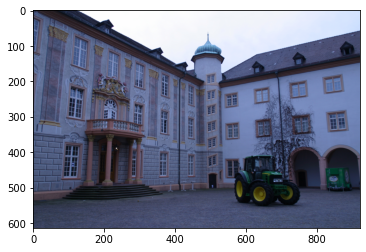

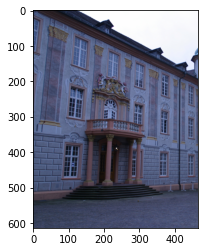

In [41]:
img_path = "./Data/0001_s.png"
I_to_crop = Image.open(img_path)
I = array_to_image(np.array(I_to_crop)[:,0:465,:])
plot_img(I_to_crop)
plot_img(I)

<span style='color:Blue'> Set of points and lines.  </span>

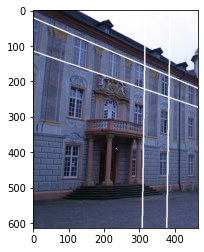

In [42]:
lines_path = "./Data/0001_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
p1,p2 = get_points(A, 613)
p3,p4 = get_points(A, 158)
p5,p6 = get_points(A, 644)
p7,p8 = get_points(A, 540)

#The line that crosses between two points is l = p1 x p2 
l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)

draw_image_lines(I.copy(), [l1,l2,l3,l4])

<span style='color:Blue'> Affine rectification.  </span>

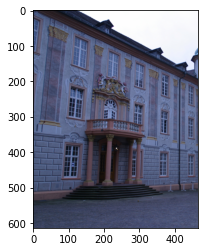

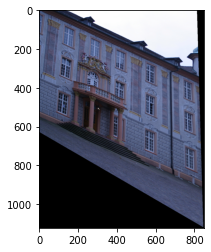

In [43]:
l_inf = get_line_inf([l1,l2,l3,l4])
Hap = get_Hap(l_inf)

I_aff_rectified, _, affine_corners = apply_H(np.array(I),Hap)

plot_img(I)
plot_img(array_to_image(I_aff_rectified))

<span style='color:Blue'> Transformed lines after affine rectification.  </span>

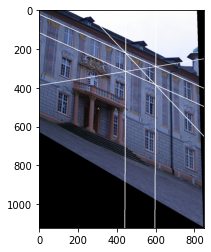

In [44]:
Hap_inv_t = np.transpose(LA.inv(Hap))

# Compute the transformed lines
lr1 = np.matmul(Hap_inv_t, l1)
lr2 = np.matmul(Hap_inv_t, l2)
lr3 = np.matmul(Hap_inv_t, l3)
lr4 = np.matmul(Hap_inv_t, l4)

# Intersection points between orthogonal lines
pi1 = np.cross(lr1, lr3)
pi2 = np.cross(lr1, lr4)
pi3 = np.cross(lr2, lr3)
pi4 = np.cross(lr2, lr4)

# Diagonal (transformed) lines that cross the intersection points between orthogonal lines
lr5 = np.cross(pi1,pi4)
lr6 = np.cross(pi2,pi3)

corrected_lines = correct_transformed_lines([lr1,lr2,lr3,lr4,lr5,lr6], affine_corners)

draw_image_lines(array_to_image(I_aff_rectified), corrected_lines)

<span style='color:Blue'> Angles between parallel lines before and after affine rectification.  </span>

In [45]:
# Angle between parallel lines (l1-l2 and l3-l4) before the affine rectification
angle_l1_l2 = get_angle(l1, l2)
angle_l3_l4 = get_angle(l3, l4)
print(f'Angles between parallel lines before the affine rectification --> l1-l2: {angle_l1_l2:.3f};  l3-l4: {angle_l3_l4:.3f}')

# Angle between parallel lines (lr1-lr2 and lr3-lr4) after the affine rectification (should be 0)
angle_lr1_lr2 = get_angle(lr1, lr2)
angle_lr3_lr4 = get_angle(lr3, lr4)
print(f'Angles between parallel lines after the affine rectification --> lr1-lr2: {angle_lr1_lr2:.3f};  lr3-lr4: {angle_lr3_lr4:.3f}')

Angles between parallel lines before the affine rectification --> l1-l2: 4.421;  l3-l4: 0.125
Angles between parallel lines after the affine rectification --> lr1-lr2: 0.000;  lr3-lr4: 0.000


<span style='color:Blue'> Metric rectification.  </span>

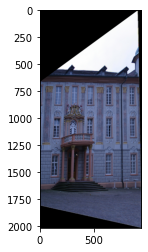

In [46]:
#Two pairs of orthogonal lines (lr1-lr3 and lr5-lr6)
Hsa = get_Hsa([[lr1,lr3], [lr5,lr6]])

I_metric_rectified, _, metric_corners = apply_H(I_aff_rectified, Hsa, affine_corners)
plot_img(array_to_image(I_metric_rectified))

<span style='color:Blue'> Transformed lines after metric rectification.  </span>

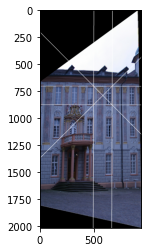

In [47]:
Has_t = np.transpose(LA.inv(Hsa))

# Compute the transformed lines
lrm1 = np.matmul(Has_t, lr1)
lrm2 = np.matmul(Has_t, lr2)
lrm3 = np.matmul(Has_t, lr3)
lrm4 = np.matmul(Has_t, lr4)
lrm5 = np.matmul(Has_t, lr5)
lrm6 = np.matmul(Has_t, lr6)

corrected_lines = correct_transformed_lines([lrm1,lrm2,lrm3,lrm4,lrm5,lrm6], metric_corners)

draw_image_lines(array_to_image(I_metric_rectified), corrected_lines)

<span style='color:Blue'> Angles between orthogonal lines before and after metric rectification.  </span>

In [48]:
# Angle between orthogonal lines (lr1-lr3, lr2-lr4 and lr5-lr6) before the metric rectification (not 90)
angle_lr1_lr3 = get_angle(lr1, lr3)
angle_lr2_lr4 = get_angle(lr2, lr4)
angle_lr5_lr6 = get_angle(lr5, lr6)
print(f'Angles between orthogonal lines before the metric rect. --> lr1/lr3: {angle_lr1_lr3:.2f};  lr2/lr4: {angle_lr2_lr4:.2f};  lr5/lr6: {angle_lr5_lr6:.2f}')

# Angle between orthogonal lines (lrm1-lrm3, lrm2-lrm4 and lrm5-lrm6) after the metric rectification (should be 90)
angle_lrm1_lrm3 = get_angle(lrm1, lrm3)
angle_lrm2_lrm4 = get_angle(lrm2, lrm4)
angle_lrm5_lrm6 = get_angle(lrm5, lrm6)
print(f'Angles between orthogonal lines after the metric rect. --> lrm1/lrm3: {angle_lrm1_lrm3:.2f};  lrm2/lrm4: {angle_lrm2_lrm4:.2f};  lrm5/lrm6: {angle_lrm5_lrm6:.2f}')

Angles between orthogonal lines before the metric rect. --> lr1/lr3: 113.82;  lr2/lr4: 113.82;  lr5/lr6: 124.14
Angles between orthogonal lines after the metric rect. --> lrm1/lrm3: 90.00;  lrm2/lrm4: 90.00;  lrm5/lrm6: 90.00


## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.

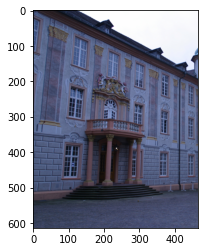

In [49]:
img_path = "./Data/0001_s.png"
I_to_crop = Image.open(img_path)
I = array_to_image(np.array(I_to_crop)[:,0:465,:])
plot_img(I)

lines_path = "./Data/0001_s_info_lines.txt"
A = np.loadtxt(lines_path)

<span style='color:Blue'> We tried two different sets of points/lines.  </span>

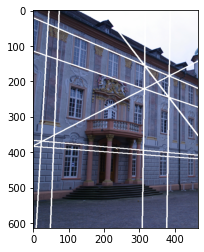

In [180]:
# set of points and lines 1
p1,p2 = get_points(A, 613)
p3,p4 = get_points(A, 158)
p5,p6 = get_points(A, 644)
p7,p8 = get_points(A, 540)
p9,p10 = get_points(A, 187)
p11,p12 = get_points(A, 208)
p13,p14 = get_points(A, 359)
p15,p16 = get_points(A, 342)

l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)
l5 = np.cross(p9,p10)
l6 = np.cross(p11,p12)
l7 = np.cross(p13,p14)
l8 = np.cross(p15,p16)

# l1 and l2 are orthogonal w.r.t l3 and l4, but l1 and l2 are parallel
l9, l10 = get_diagonal_lines([l1,l2,l3,l4])

draw_image_lines(I.copy(), [l1,l2,l3,l4,l5,l6,l7,l8,l9,l10])

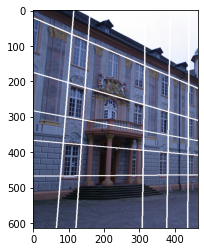

In [176]:
# set of points and lines 2
p1,p2 = get_points(A, 314)
p3,p4 = get_points(A, 613)
p5,p6 = get_points(A, 300)
p7,p8 = get_points(A, 540)
p9,p10 = get_points(A, 187)
p11,p12 = get_points(A, 283)
p13,p14 = get_points(A, 336)
p15,p16 = get_points(A, 297)
p17,p18 = get_points(A, 644)
p19,p20 = get_points(A, 169)

#The line that crosses between two points is l = p1 x p2 
l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)
l5 = np.cross(p9,p10)
l6 = np.cross(p11,p12)
l7 = np.cross(p13,p14)
l8 = np.cross(p15,p16)
l9 = np.cross(p17,p18)
l10 = np.cross(p19,p20)

draw_image_lines(I.copy(), [l1,l2,l3,l4,l5,l6,l7,l8,l9,l10])

<span style='color:Blue'> Compute M.  </span>

In [181]:
# Five pairs of two orthogonal lines
def linear_equation(l,m):
    return np.array([l[0]*m[0], 
                     (l[0]*m[1] + l[1]*m[0])/2, 
                     l[1]*m[1], 
                     (l[0]*m[2] + l[2]*m[0])/2, 
                     (l[1]*m[2] + l[2]*m[1])/2,
                     l[2]*m[2]])

eq1 = linear_equation(l1,l3)
eq2 = linear_equation(l2,l4)
eq3 = linear_equation(l5,l7)
eq4 = linear_equation(l6,l8)
eq5 = linear_equation(l9,l10)

c = SCIPY_LA.null_space(np.array([eq1, eq2, eq3, eq4, eq5]), np.array([0,0,0,0,0]))

M = [[c[0][0],   c[1][0]/2, c[3][0]/2], 
     [c[1][0]/2, c[2][0],   c[4][0]/2],
     [c[3][0]/2, c[4][0]/2, c[5][0]]]

<span style='color:Blue'> Get H version1: using SVD.  </span>

H: [[-7.92437140e-01  6.09952685e-01 -1.04936824e-03]
 [-6.09952461e-01 -7.92437810e-01 -5.58313131e-04]
 [-1.17210367e-03  1.97636683e-04  9.99999294e-01]]


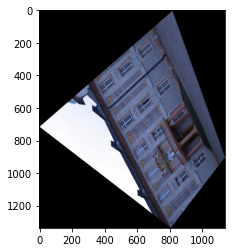

In [189]:
U,D,V = LA.svd(M)

H = U

print(f'H: {H}')

I_metric_rectified, _, _ = apply_H(np.array(I).copy(), H)
plot_img(array_to_image(I_metric_rectified))

<span style='color:Blue'> Get H version2: using K and v from M. (it fails for set of points 2)  </span>

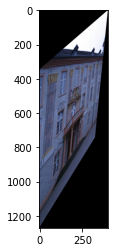

In [188]:
# S = K*K^T
S = [[M[0][0], M[0][1]], 
     [M[1][0], M[1][1]]]

K = LA.cholesky(S)

K_inv = LA.inv(K)
Hsa =  [[K_inv[0][0], K_inv[0][1], 0],
         [K_inv[1][0], K_inv[1][1], 0],
         [0, 0, 1]]

# v^t*K*K^t = v^t*S = [M[2][0], M[2][1]]
# ..
# v^t = [M[2][0], M[2][1]] * S^-1

v = np.matmul(np.array([M[2][0], M[2][1]]), LA.inv(S))

Hap = [[1, 0, 0],
        [0, 1, 0],
        [v[0], v[1], 1]]

H = np.matmul(Hsa,Hap)

I_metric_rectified, _, _ = apply_H(np.array(I).copy(), H)
plot_img(array_to_image(I_metric_rectified))